In [133]:
calname='et_cal48'
import glob
import rhessys.utilities as rut
import hydro.objective_fxns as ofx
import ProgressBar as pb
import ipyparallel as par
import os
from pymail import alert

In [134]:
c = par.Client()

In [135]:
len(c.ids)

8

In [136]:
view = c.load_balanced_view()

In [137]:
VCM = pd.read_pickle('./data/VCM_2.pcl')

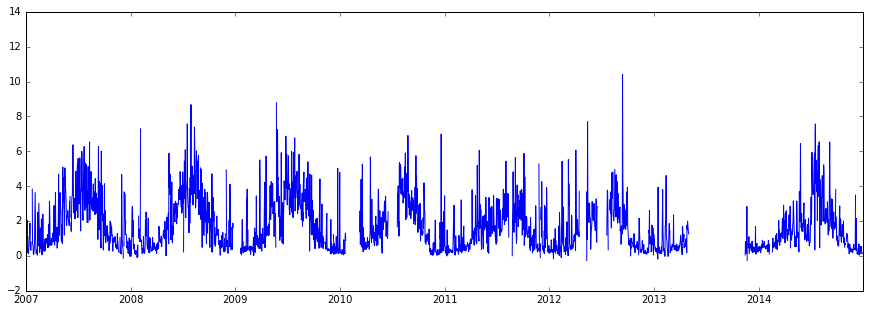

In [138]:
plt.figure(figsize=(15,5))
plt.plot(VCM.index, VCM.ET)

In [139]:
VCM.ET.max()

12.480304882495915

In [140]:
files = glob.glob('/RHESSys/jemez/out/%s/%s_*basin.daily'%(calname,calname))

In [141]:
len(files)

20000

In [142]:
tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_0_basin.daily'%(calname,calname))
#datmin = tmp.index.min()
#datmax = tmp.index.max()

datmin = '2010-10-01'
datmax = '2011-09-30'

In [143]:
datmin

'2010-10-01'

In [144]:
datmax

'2011-09-30'

In [145]:
print VCM.index.max()
print VCM.index.min()

2015-01-01 00:00:00
2007-01-01 00:00:00


In [146]:
print tmp.index.min()
print tmp.index.max()

2010-10-01 00:00:00
2013-04-24 00:00:00


In [147]:
%%px
calname='et_cal48'
import rhessys.utilities as rut
import hydro.objective_fxns as ofx
import os
dat = pd.read_pickle('/Volumes/Users/Theo/projects/RHESSys/jemez/data/VCM_2.pcl') # load ET in mm

#wys = [2010,2011,2012]

tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_0_basin.daily'%(calname,calname))
#datmin = tmp.index.min()
#datmax = dat.index.max()

datmin = '2010-10-01'
datmax = '2011-09-30'

#print datmin
#print datmax
dat = dat.loc[datmin:datmax]

#dat.loc['2007-10-01':'2008-1-15'] = np.NaN
#dat.loc['2008-06-15':'2009-1-15'] = np.NaN
#dat.loc['2009-06-15':'2010-1-15'] = np.NaN
#dat.loc['2010-06-15':'2011-1-15'] = np.NaN
#dat.loc['2011-06-15':'2011-12-31'] = np.NaN

#dat.dropna(inplace=True)

dat2 = dat.resample('W',how='mean')
dat3 = dat.resample('M',how='mean')

# generate lists of start and stop times
#strts = []
#nds = []
#for wy in wys:
#    tmp2 = tmp.loc[tmp.wateryear==wy]
#    
#    strts.append(tmp2.loc[(tmp2.precip>0) | (tmp2.snowmelt>0)].index[0])
#    nds.append(tmp2.loc[(tmp2.precip>0) | (tmp2.snowmelt>0)].index[-1])

    
# nan out periods not considered in the calibration    
#for wy,strt,nd in zip(wys,strts,nds):
#    dat.loc['%s-10-01'%(wy-1):strt] = np.NaN
#    dat.loc[nd:'%s-09-30'%wy] = np.NaN
    
    
#print tmp.index.max()

In [148]:
def compute_ns(fl,clean):
    idx = int(fl.split('_')[-2])
    tmp = rut.readRHESSysBasin(fl) #load the data
    
    # save the data as compressed npz
    #np.savez('/Volumes/data/RHESSys_out/Vcm/%s/%s_%s_basin.daily.npz'%(calname,calname,idx),tmp.as_matrix())
    #if clean == True:
    #    os.remove(fl)
    
    # save the parameters
    #pth = '/RHESSys/jemez/out/%s/%s_%s_*'%(calname,calname,idx)
    #out = '/Volumes/data/RHESSys_out/Vcm/%s/%s_%s_params.pcl'%(calname,calname,idx)
    #rut.save_params(pth,out,clean)
    
    tmp = tmp.loc[datmin:datmax].copy() # crop the data
    
    #tmp.loc['2007-10-01':'2008-1-15'] = np.NaN
    #tmp.loc['2008-06-01':'2009-1-15'] = np.NaN
    #tmp.loc['2009-06-01':'2010-1-15'] = np.NaN
    #tmp.loc['2010-06-15':'2011-1-15'] = np.NaN
    #tmp.loc['2011-06-15':'2011-12-31'] = np.NaN

    tmp.dropna(inplace=True)

    tmp2 = tmp.resample('W',how='mean')
    tmp3 = tmp.resample('M',how='mean')
    
    nashsut = round(ofx.nashsut(dat.ET,tmp.ET),4)
    #pbias = round(ofx.wy_percent_bias(dat.ET,tmp.ET),4)
    pe = round(ofx.percenterror(dat.ET,tmp.ET),4)
    
    nashsut2 = round(ofx.nashsut(dat2.ET,tmp2.ET),4)
    #pbias2 = round(ofx.wy_percent_bias(dat2.ET,tmp2.ET),4)
    pe2 = round(ofx.percenterror(dat2.ET,tmp2.ET),4)
    
    nashsut3 = round(ofx.nashsut(dat3.ET,tmp3.ET),4)
    #pbias3 = round(ofx.wy_percent_bias(dat3.ET,tmp3.ET),4)
    pe3 = round(ofx.percenterror(dat3.ET,tmp3.ET),4)
    
    Q = tmp.streamflow.sum()/len(tmp)
    
    return idx,nashsut,pe,nashsut2,pe2,nashsut3,pe3,Q

In [149]:
res = view.map(compute_ns,files,np.repeat(False,len(files)))

In [150]:
p = pb.ProgressBar(len(files))

In [151]:
import time

In [152]:
while res.ready() == False:
    p.animate_ipython(res.progress)
    time.sleep(2)

alert.send_alert('barnhatb@colorado.edu','Processing %s has finished'%calname,'Your script has finished')

[*****************99%******************]  19876 of 20000 complete


In [153]:
len(files)

20000

In [154]:
res.progress

20000

In [155]:
calname

'et_cal48'

In [156]:
res.ready()

True

In [157]:
idx,nse,pe,nse2,pe2,nashsut3,pe3,Q = zip(*res.result)

In [158]:
#gw1 = np.loadtxt('/RHESSys/jemez/scripts/%s_gw1.txt'%calname)
#gw2 = np.loadtxt('/RHESSys/jemez/scripts/%s_gw2.txt'%calname)
#ksat = np.loadtxt('/RHESSys/jemez/scripts/%s_ksat.txt'%calname)
#m = np.loadtxt('/RHESSys/jemez/scripts/%s_m.txt'%calname)
rd = np.loadtxt('/RHESSys/jemez/scripts/%s_rd.txt'%calname)
#sd = np.loadtxt('/RHESSys/jemez/scripts/%s_sd.txt'%calname)
#gs = np.loadtxt('/RHESSys/jemez/scripts/%s_gs.txt'%calname)
#p_surf = np.loadtxt('/RHESSys/jemez/scripts/%s_p0.txt'%calname)
#pdecay = np.loadtxt('/RHESSys/jemez/scripts/%s_pdecay.txt'%calname)
#po = np.loadtxt('/RHESSys/jemez/scripts/%s_po.txt'%calname)
#pa = np.loadtxt('/RHESSys/jemez/scripts/%s_pa.txt'%calname)
lai = np.loadtxt('/RHESSys/jemez/scripts/%s_lai.txt'%calname)

In [159]:
df = pd.DataFrame({'rd':rd,'lai':lai, \
'idx':np.arange(0,len(files))})

#df = pd.DataFrame({'gw1':gw1,'gw2':gw2,'ksat':ksat,'m':m,'rd':rd,'gs':gs,'p0':p_surf,'pdecay':pdecay,
#                   'idx':np.arange(0,50000)})
tmpdf = pd.DataFrame({'nse':nse,'pe':pe,'nse_weekly':nse2,'pe_weekly':pe2,
                      'nse_monthly':nashsut3,'pe_monthly':pe3,'idx':idx,'Q':Q})

In [160]:
df = pd.merge(df,tmpdf,on='idx')

In [161]:
def metric_weekly(df):
    bias = 1.-(df.pe_weekly/100.)
    nse = df.nse_weekly

    
    return np.nanmean([bias,nse])

In [162]:
def metric_monthly(df):
    bias = 1.-(df.pe_monthly/100.)
    nse = df.nse_monthly

    
    return np.nanmean([bias,nse])

In [163]:
df['weekly_metric'] = df.apply(metric_weekly,axis=1)
df['monthly_metric'] = df.apply(metric_monthly,axis=1)

In [164]:
df3= df.loc[df.Q!=0]

In [165]:
len(df3)

5513

In [166]:
df.describe()

,idx,lai,rd,Q,nse,nse_monthly,nse_weekly,pe,pe_monthly,pe_weekly,weekly_metric,monthly_metric
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,1.496329,4.506136,0.000042,-1.051999,-0.809051,-1.202095,1.454472,0.487001,0.735071,-0.104723,0.093040
std,5773.647028,0.576952,2.021738,0.000160,0.558735,1.331724,0.897328,0.168296,0.128650,0.116559,0.449232,0.666475
min,0.000000,0.500000,1.001000,0.000000,-2.189200,-3.247800,-3.010200,1.171600,0.319400,0.569000,-1.010036,-1.127356
25%,4999.750000,0.990000,2.756000,0.000000,-1.541000,-2.201400,-2.032800,1.318600,0.365900,0.647500,-0.520469,-0.603728
50%,9999.500000,1.500000,4.500500,0.000000,-0.737950,-0.021350,-0.626500,1.393500,0.448300,0.678100,0.183442,0.487062
75%,14999.250000,2.000000,6.260000,0.000015,-0.663600,0.241525,-0.568675,1.571200,0.620500,0.815100,0.212440,0.618954
max,19999.000000,2.490000,7.999000,0.004975,-0.420100,0.514200,-0.413500,1.793900,0.691300,0.987200,0.290156,0.755499


In [174]:
df2 = df3.loc[df3.monthly_metric>np.percentile(df3.monthly_metric,95)]

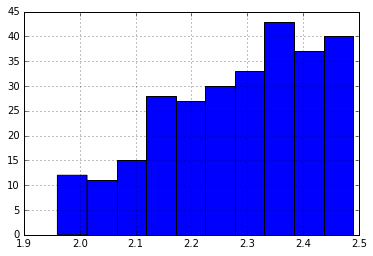

In [175]:
df2.lai.hist()

In [173]:
np.percentile(df3.monthly_metric,95)

0.7111248

In [171]:
df2

,idx,lai,rd,Q,nse,nse_monthly,nse_weekly,pe,pe_monthly,pe_weekly,weekly_metric,monthly_metric
52,52,2.21,2.749,0.000175,-0.7642,0.4085,-0.5637,1.3886,0.3500,0.6674,0.214813,0.702500
63,63,2.22,2.780,0.000160,-0.7617,0.4059,-0.5626,1.3861,0.3507,0.6659,0.215371,0.701197
109,109,2.23,2.540,0.000291,-0.7896,0.4308,-0.5848,1.4074,0.3451,0.6801,0.204200,0.713674
281,281,2.18,2.649,0.000218,-0.7755,0.4140,-0.5705,1.3980,0.3494,0.6721,0.211390,0.705253
298,298,2.47,2.734,0.000189,-0.7985,0.4221,-0.6008,1.3953,0.3491,0.6780,0.196210,0.709305
324,324,2.42,2.605,0.000247,-0.8060,0.4338,-0.6044,1.4043,0.3459,0.6832,0.194384,0.715171
377,377,2.47,2.368,0.000451,-0.8378,0.4567,-0.6319,1.4262,0.3398,0.6971,0.180565,0.726651
400,400,2.37,2.221,0.000640,-0.8439,0.4631,-0.6380,1.4401,0.3368,0.7022,0.177489,0.729866
471,471,2.34,2.401,0.000422,-0.8193,0.4488,-0.6130,1.4216,0.3410,0.6918,0.190041,0.722695
536,536,2.36,2.529,0.000305,-0.8065,0.4389,-0.6022,1.4098,0.3439,0.6853,0.195474,0.717731


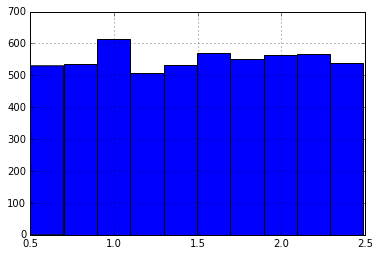

In [169]:
df3.lai.hist()

In [74]:
df2.iloc[np.random.randint(0,len(df2),1)]

,idx,lai,rd,Q,nse,nse_monthly,nse_weekly,pe,pe_monthly,pe_weekly,weekly_metric,monthly_metric
18941,18941,0.25,1.333,0.135417,-0.1315,-0.1264,-0.1328,0.9629,0.4545,0.5387,0.430906,0.434527


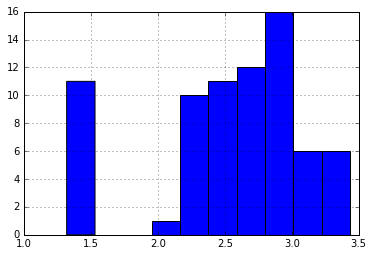

In [71]:
df2.rd.hist()

In [260]:
df.pe_monthly.min()

0.37830000000000003

In [261]:
master = df.copy()

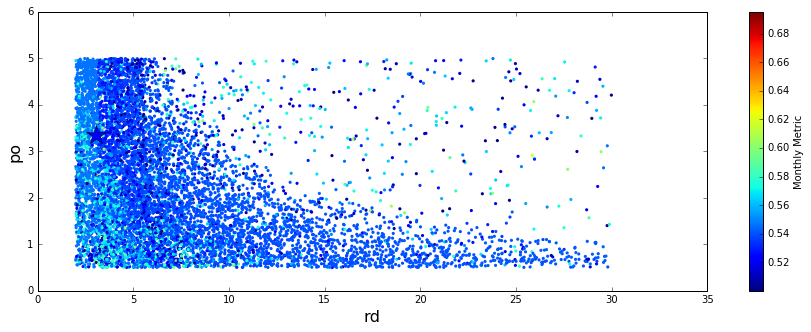

In [264]:
df = master.loc[master.monthly_metric>0.5]
x = 'rd'
y = 'po'

plt.figure(figsize=(15,5))
plt.scatter(df[x],df[y],s=10,c=df.monthly_metric,edgecolors='none')
plt.colorbar(label = 'Monthly Metric')
plt.xlabel(x, fontsize=16)
plt.ylabel(y, fontsize=16)
plt.plot(df2[x],df2[y],'*',markersize=20)

In [41]:
plt.hist(df.gs.as_matrix(),100);

AttributeError: 'DataFrame' object has no attribute 'gs'

In [75]:
calname

'et_cal46'

In [176]:
df.to_pickle('./data/%s.pcl'%calname)

In [128]:
tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_944_basin.daily'%(calname,calname)).loc[datmin:datmax]

In [129]:
VCM = VCM[datmin:datmax]

In [130]:
tmp2 = tmp.resample('W', how='mean')
VCM2 = VCM.resample('W',how='mean')
tmp3 = tmp.resample('M', how='mean')
VCM3 = VCM.resample('M',how='mean')

In [131]:
calname

'et_cal47'

(734077.0, 735003.0)

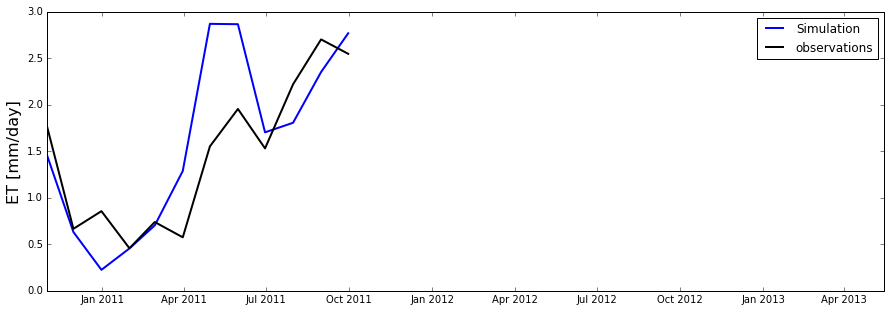

In [132]:
#idx = df2.index[ct]
#idx= int(df2.idx)
#tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_%s_basin.daily'%(calname,calname,idx)).loc[datmin:datmax]

#tmp.loc['2007-10-01':'2008-1-15'] = np.NaN
#tmp.loc['2008-06-01':'2009-1-15'] = np.NaN
#tmp.loc['2009-06-01':'2010-1-15'] = np.NaN
#tmp.loc['2010-06-15':'2011-1-15'] = np.NaN
#tmp.loc['2011-06-15':'2011-12-31'] = np.NaN

tmp2 = tmp.resample('W', how='mean')
plt.figure(figsize=(15,5))
plt.plot(tmp3.index,tmp3.ET,'-b',label='Simulation',lw=2)
plt.plot(VCM3.index,VCM3.ET,'-k',label='observations',lw=2)
plt.legend(loc='upper right')
plt.ylabel('ET [mm/day]', fontsize=16)
plt.xlim('2010-11-01','2013-5-15')
#plt.title('ET CAL10 2937: metric: 0.51', fontsize=16)
#plt.savefig('./figures/et_cal_07_best_weekly.png')
#ct += 1

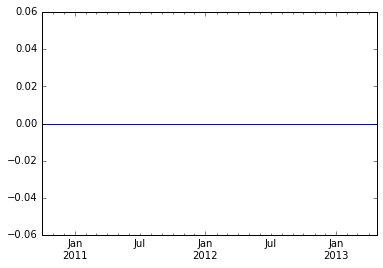

In [46]:
tmp.streamflow.plot()

In [112]:
tmp2.columns

Index([u'basinID', u'pot_surface_infil', u'snow_thr', u'sat_def_z', u'sat_def',
       u'rz_storage', u'unsat_stor', u'rz_drainage', u'unsat_drain', u'cap',
       u'evap', u'snowpack', u'trans', u'baseflow', u'return', u'streamflow',
       u'psn', u'lai', u'gw.Qout', u'gw.storage', u'detention_store',
       u'%sat_area', u'litter_store', u'canopy_store', u'%snow_cover',
       u'snow_subl', u'trans_var', u'acc_trans', u'acctransv_var', u'pet',
       u'dC13', u'precip', u'pcp_assim', u'mortf', u'tmax', u'tmin', u'tavg',
       u'vpd', u'snowfall', u'recharge', u'gpsn', u'resp', u'gs', u'rootdepth',
       u'plantc', u'snowmelt', u'canopysubl', u'routedstreamflow',
       u'canopy_snow', u'height', u'evap_can', u'evap_lit', u'evap_soil',
       u'litrc', u'Kdown', u'Ldown', u'Kup', u'Lup', u'Kstar_can',
       u'Kstar_soil', u'Kstar_snow', u'Lstar_can', u'Lstar_soil',
       u'Lstar_snow', u'LE_canopy', u'LE_soil', u'LE_snow', u'Lstar_strat',
       u'canopydrip', u'ga', u'wateryear'

In [154]:
tower = pd.read_csv('./data/AMF_US-Vcm_BASE-BADM_4-1/AMF_US-Vcm_BASE_HH_4-1.csv', skiprows=2,na_values=-9999)

In [155]:
def make_dt(dt):
    dt = str(dt)

    YYYY = dt[0:4]
    MM = dt[4:6]
    DD = dt[6:8]
    HH = dt[8:10]
    mm = dt[10:12]

    return '%s-%s-%s %s:%s'%(YYYY,MM,DD,HH,mm)
    

In [156]:
tower.index = pd.DatetimeIndex(tower.TIMESTAMP_START.map(make_dt))

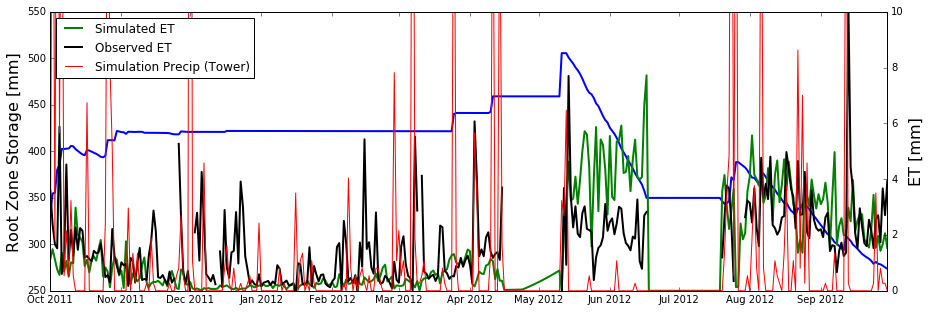

In [203]:
strt = '2011-10-01'
nd = '2012-09-30'
plt.figure(figsize=(15,5))
plt.plot(tmp[strt:nd].index,tmp[strt:nd].rz_storage,'-b',label='Root Zone Storage',lw=2)
ax1 = plt.gca()
ax1.set_ylabel('Root Zone Storage [mm]', fontsize=16)
ax2 = ax1.twinx()
#ax2.plot(tmp[strt:nd].index,tmp[strt:nd].precip,'r',label = 'precipitation',lw=2)
#ax2.plot(tower[strt:nd].index,tower[strt:nd].P*10,'y',label = 'tower precip')
ax2.plot(tmp[strt:nd].index,tmp[strt:nd].ET,'g',label = 'Simulated ET',lw=2)
ax2.plot(VCM[strt:nd].index,VCM[strt:nd].ET,'k',label = 'Observed ET',lw=2)
#ax2.plot(VCM[strt:nd].index,VCM[strt:nd].RH,'m',label = 'RH',lw=2)
#ax2.plot(tmp[strt:nd].index,tmp[strt:nd].rz_storage,'-b',label='Root Zone Storage',lw=2)
ax2.set_ylabel('ET [mm]', fontsize=16)
plt.plot(tmp[strt:nd].index,tmp[strt:nd].precip,'-r',label='Simulation Precip (Tower)',lw=1)
#plt.plot(tmp[strt:nd].index,tmp[strt:nd].trans,'-g',label='Simulation',lw=2)
#plt.plot(tmp2.index,tmp2.rz_storage,'-b',label='Simulation',lw=2)
#ax1.set_ylim(7300,7500)
ax2.set_ylim(0,10)
ax2.legend(loc = 'upper left')

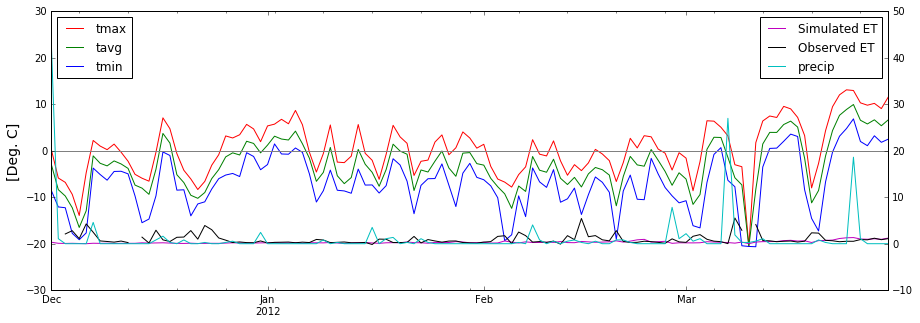

In [219]:
strt = '2011-12-01'
nd = '2012-03-30'
plt.figure(figsize=(15,5))

tmp.tmax.plot(c='r')
tmp.tavg.plot(c='g')
tmp.tmin.plot(c='b')
ax1 = plt.gca()
ax1.set_xlim(strt,nd)
ax1.axhline(0,color='0.5')
ax1.set_ylabel('[Deg. C]', fontsize=14)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.sca(ax2)
tmp.ET.plot(c = 'm',label='Simulated ET')
VCM.ET.plot(c = 'k',label='Observed ET')
tmp.precip.plot(c='c')
ax2.set_xlim(strt,nd)
ax2.legend(loc='upper right')

In [268]:
tmp.streamflow.describe()

count    937.000000
mean       0.046660
std        0.911810
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       24.852352
Name: streamflow, dtype: float64

In [311]:
tmp = rut.readRHESSysBasin('/RHESSys/jemez/test_flow_basin.daily').loc[datmin:datmax]

In [312]:
print tmp.columns

Index([u'basinID', u'pot_surface_infil', u'snow_thr', u'sat_def_z', u'sat_def',
       u'rz_storage', u'unsat_stor', u'rz_drainage', u'unsat_drain', u'cap',
       u'evap', u'snowpack', u'trans', u'baseflow', u'return', u'streamflow',
       u'psn', u'lai', u'gw.Qout', u'gw.storage', u'detention_store',
       u'%sat_area', u'litter_store', u'canopy_store', u'%snow_cover',
       u'snow_subl', u'trans_var', u'acc_trans', u'acctransv_var', u'pet',
       u'dC13', u'precip', u'pcp_assim', u'mortf', u'tmax', u'tmin', u'tavg',
       u'vpd', u'snowfall', u'recharge', u'gpsn', u'resp', u'gs', u'rootdepth',
       u'plantc', u'snowmelt', u'canopysubl', u'routedstreamflow',
       u'canopy_snow', u'height', u'evap_can', u'evap_lit', u'evap_soil',
       u'litrc', u'Kdown', u'Ldown', u'Kup', u'Lup', u'Kstar_can',
       u'Kstar_soil', u'Kstar_snow', u'Lstar_can', u'Lstar_soil',
       u'Lstar_snow', u'LE_canopy', u'LE_soil', u'LE_snow', u'Lstar_strat',
       u'canopydrip', u'ga', u'wateryear'

(-5, 30)

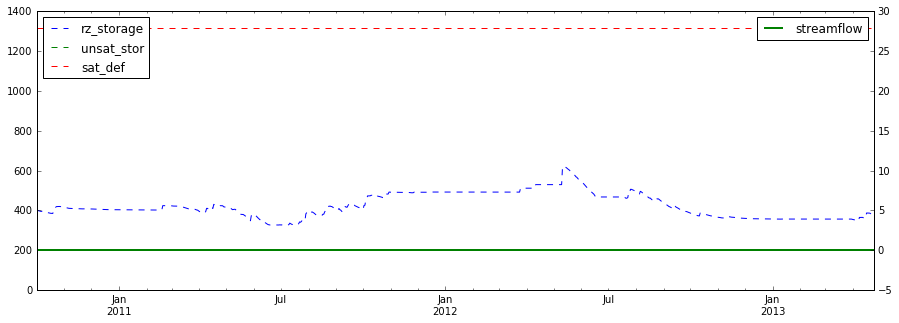

In [43]:
#tmp = rut.readRHESSysBasin('/RHESSys/jemez/test_flow_basin.daily').loc[datmin:datmax]
plt.figure(figsize=(15,5))
tmp.rz_storage.plot(ls='--')
tmp.unsat_stor.plot(ls='--')
tmp.sat_def.plot(ls='--')
plt.legend(loc='upper left')
#plt.ylim(-20,1300)

ax1 = plt.gca()
ax2 = ax1.twinx()
plt.sca(ax2)

#tmp.snowmelt.plot(c='m')
tmp.streamflow.plot(c='g',lw=2)
#tmp.precip.plot(c='y')
#tmp.rz_drainage.plot(c='c')
plt.legend()
plt.ylim(-5,30)


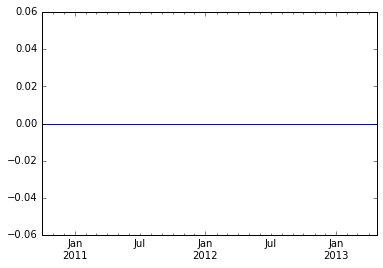

In [297]:
tmp['gw.Qout'].plot()

In [110]:
%%px 
calname

Out[0:4]: 'et_cal22'

Out[1:4]: 'et_cal22'

Out[2:4]: 'et_cal22'

Out[3:4]: 'et_cal22'

Out[4:4]: 'et_cal22'

Out[5:4]: 'et_cal22'

Out[6:4]: 'et_cal22'

Out[7:4]: 'et_cal22'

In [38]:
df2.head()

,gs,idx,rd,nse,nse_weekly,pbias,pbias_weekly,pe,pe_weekly,weekly_metric
211,0.0009,211,1.99,-0.1857,0.2913,0.0883,0.0911,0.9908,0.6397,0.642451
363,0.0006,363,1.99,-0.1857,0.2913,0.0883,0.0911,0.9908,0.6397,0.642451
950,0.0013,950,1.99,-0.1857,0.2913,0.0883,0.0911,0.9908,0.6397,0.642451
969,0.0004,969,1.99,-0.1857,0.2913,0.0883,0.0911,0.9908,0.6397,0.642451
1105,0.0031,1105,1.99,-0.1857,0.2913,0.0883,0.0911,0.9908,0.6397,0.642451


In [64]:
tmp.columns

Index([u'basinID', u'pot_surface_infil', u'snow_thr', u'sat_def_z', u'sat_def',
       u'rz_storage', u'unsat_stor', u'rz_drainage', u'unsat_drain', u'cap',
       u'evap', u'snowpack', u'trans', u'baseflow', u'return', u'streamflow',
       u'psn', u'lai', u'gw.Qout', u'gw.storage', u'detention_store',
       u'%sat_area', u'litter_store', u'canopy_store', u'%snow_cover',
       u'snow_subl', u'trans_var', u'acc_trans', u'acctransv_var', u'pet',
       u'dC13', u'precip', u'pcp_assim', u'mortf', u'tmax', u'tmin', u'tavg',
       u'vpd', u'snowfall', u'recharge', u'gpsn', u'resp', u'gs', u'rootdepth',
       u'plantc', u'snowmelt', u'canopysubl', u'routedstreamflow',
       u'canopy_snow', u'height', u'evap_can', u'evap_lit', u'evap_soil',
       u'litrc', u'Kdown', u'Ldown', u'Kup', u'Lup', u'Kstar_can',
       u'Kstar_soil', u'Kstar_snow', u'Lstar_can', u'Lstar_soil',
       u'Lstar_snow', u'LE_canopy', u'LE_soil', u'LE_snow', u'Lstar_strat',
       u'canopydrip', u'ga', u'wateryear'

In [181]:
tmp.lai.min()

1.621389

In [182]:
tmp.lai.max()

2.2184819999999998

In [183]:
np.mean([tmp.lai.min(),tmp.lai.max()])

1.9199354999999998

In [75]:
tmp.streamflow.tail()

2011-12-27    0
2011-12-28    0
2011-12-29    0
2011-12-30    0
2011-12-31    0
Name: streamflow, dtype: float64

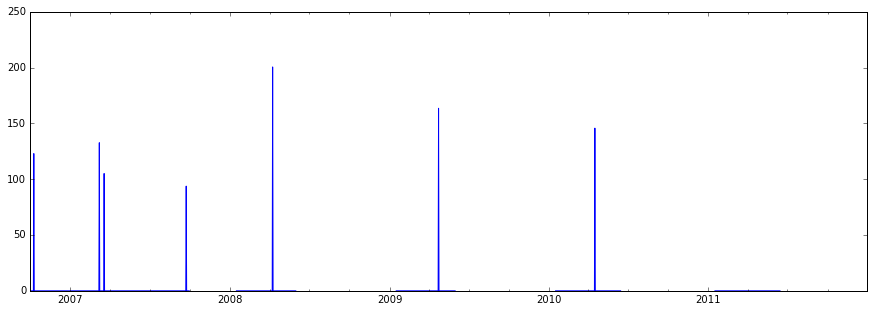

In [74]:
plt.figure(figsize=(15,5))
tmp.streamflow.plot()

In [173]:
tmp.lai.min()-1.2412269999999999

2.4430480000000001

In [176]:
tmp.lai.min()*0.663

2.442674325

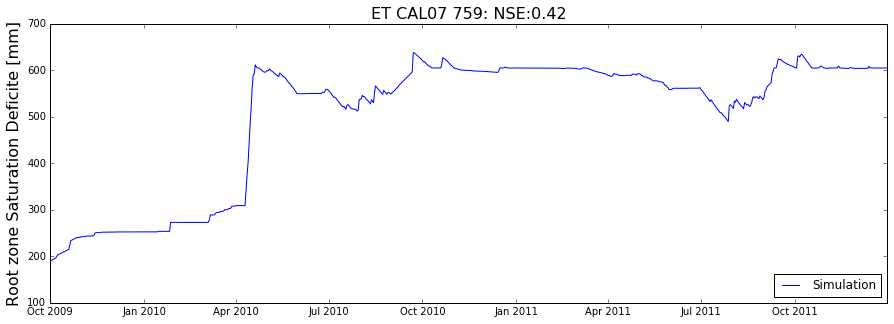

In [111]:
plt.figure(figsize=(15,5))
plt.plot(tmp.index,tmp.rz_storage,'-b',label='Simulation')
#plt.plot(VCM.index,VCM.ET,'-k',label='observations')
plt.legend(loc='lower right')
plt.ylabel('Root zone Saturation Deficite [mm]', fontsize=16)
plt.title('ET CAL07 759: NSE:0.42', fontsize=16)
plt.savefig('./figures/et_cal_07_best_weekly_rootzone_sat_def.png')

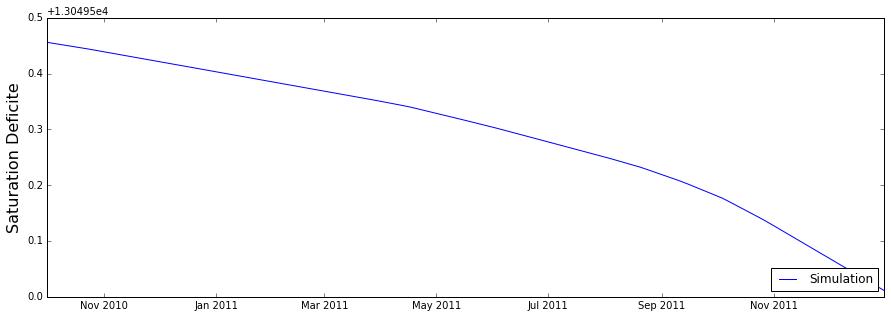

In [132]:
plt.figure(figsize=(15,5))
plt.plot(tmp.index,tmp.sat_def,'-b',label='Simulation')
#plt.plot(VCM.index,VCM.ET,'-k',label='observations')
plt.legend(loc='lower right')
plt.ylabel('Saturation Deficite', fontsize=16)

In [114]:
tmp.columns

Index([u'basinID', u'pot_surface_infil', u'snow_thr', u'sat_def_z', u'sat_def',
       u'rz_storage', u'unsat_stor', u'rz_drainage', u'unsat_drain', u'cap',
       u'evap', u'snowpack', u'trans', u'baseflow', u'return', u'streamflow',
       u'psn', u'lai', u'gw.Qout', u'gw.storage', u'detention_store',
       u'%sat_area', u'litter_store', u'canopy_store', u'%snow_cover',
       u'snow_subl', u'trans_var', u'acc_trans', u'acctransv_var', u'pet',
       u'dC13', u'precip', u'pcp_assim', u'mortf', u'tmax', u'tmin', u'tavg',
       u'vpd', u'snowfall', u'recharge', u'gpsn', u'resp', u'gs', u'rootdepth',
       u'plantc', u'snowmelt', u'canopysubl', u'routedstreamflow',
       u'canopy_snow', u'height', u'evap_can', u'evap_lit', u'evap_soil',
       u'litrc', u'Kdown', u'Ldown', u'Kup', u'Lup', u'Kstar_can',
       u'Kstar_soil', u'Kstar_snow', u'Lstar_can', u'Lstar_soil',
       u'Lstar_snow', u'LE_canopy', u'LE_soil', u'LE_snow', u'Lstar_strat',
       u'canopydrip', u'ga', u'wateryear'

In [58]:
df.gs.min()

0.0001

In [ ]:
plt.figure()

In [90]:
df.loc[df.pbias==df.pbias.min()]

,gs,gw1,gw2,idx,ksat,m,p0,pdecay,rd,nse,nse_weekly,pbias,pbias_weekly,pe,pe_weekly,weekly_metric
16391,0.0003,0.0481,0.513,16391,42.3,16.475,0.499,518.584,6.57,-3.5109,-0.0037,0.5375,0.5363,2.1007,1.3416,0.23


In [87]:
df2

,gs,gw1,gw2,idx,ksat,m,p0,pdecay,rd,nse,nse_weekly,pbias,pbias_weekly,pe,pe_weekly,weekly_metric
2937,0,0.0017,0.809,2937,149.7,15.193,0.012,5264.535,5.32,-3.5717,0.0013,0.5526,0.505,2.1198,1.3412,0.24815


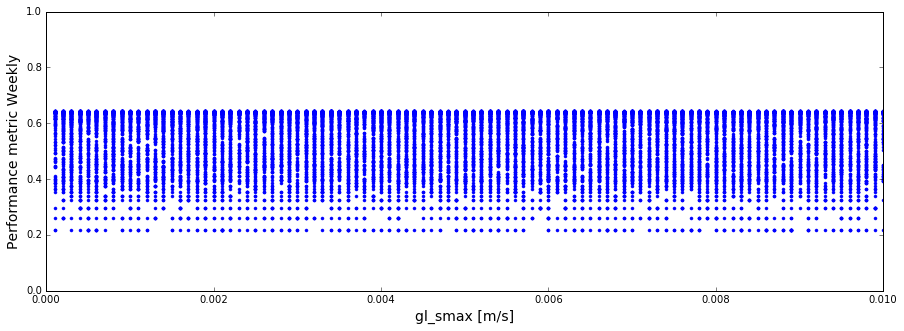

In [40]:
plt.figure(figsize=(15,5))
plt.plot(df.gs,df.weekly_metric,'.')
plt.ylim(0,1)
#plt.axvline(df2.gs.as_matrix(),c='r')
plt.ylabel('Performance metric Weekly', fontsize=14)
plt.xlabel('gl_smax [m/s]', fontsize=14)

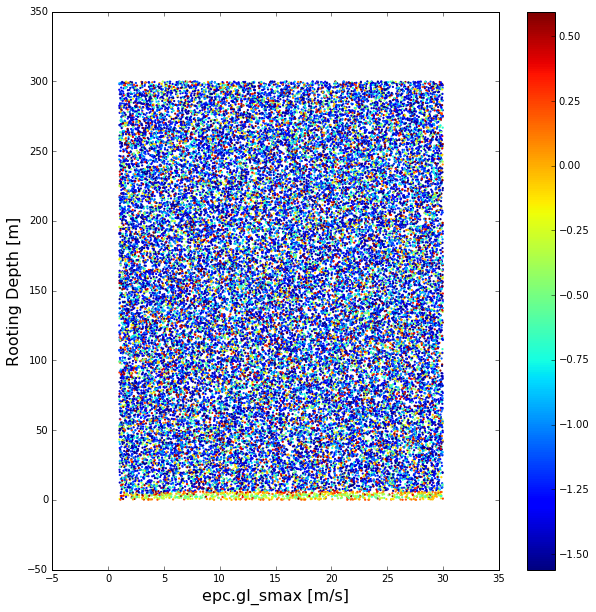

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(df.sd,df.rd,s=5,c=df.weekly_metric,edgecolor='none')
plt.colorbar()
plt.xlabel('epc.gl_smax [m/s]', fontsize=16)
plt.ylabel('Rooting Depth [m]', fontsize=16)

(0, 1)

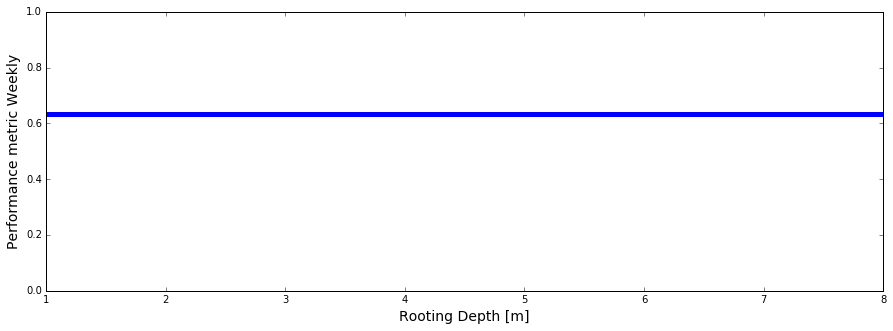

In [46]:
plt.figure(figsize=(15,5))
plt.plot(df.rd,df.weekly_metric,'.')
plt.xlabel('Rooting Depth [m]', fontsize=14)
plt.ylabel('Performance metric Weekly', fontsize=14)
#plt.axvline(df2.rd.as_matrix(),c='r')
plt.ylim(0,1)

(0, 1)

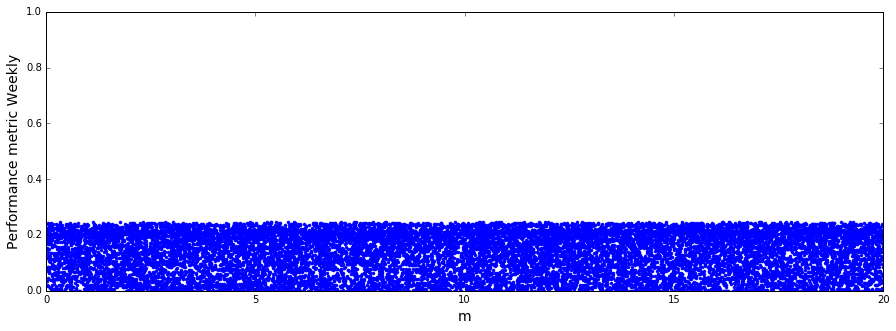

In [83]:
plt.figure(figsize=(15,5))
plt.plot(df.m,df.weekly_metric,'.')
plt.xlabel('m', fontsize=14)
plt.ylabel('Performance metric Weekly', fontsize=14)
#plt.axvline(df2.m.as_matrix(),c='r')
plt.ylim(0,1)

In [45]:
VCM.index.max()

Timestamp('2011-12-31 00:00:00', offset='D')

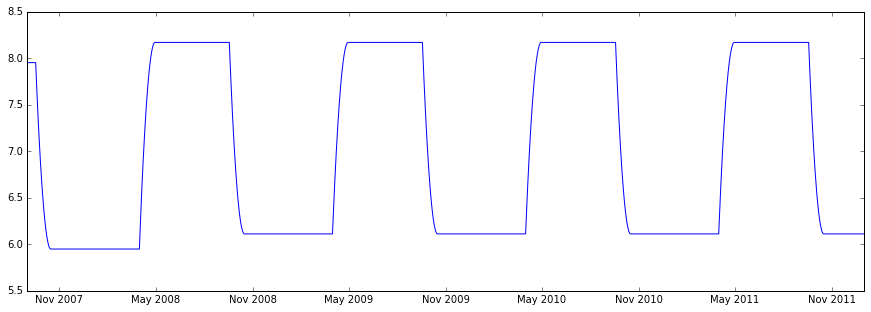

In [35]:
plt.figure(figsize=(15,5))
plt.plot(tmp.index, tmp.lai,'-b')

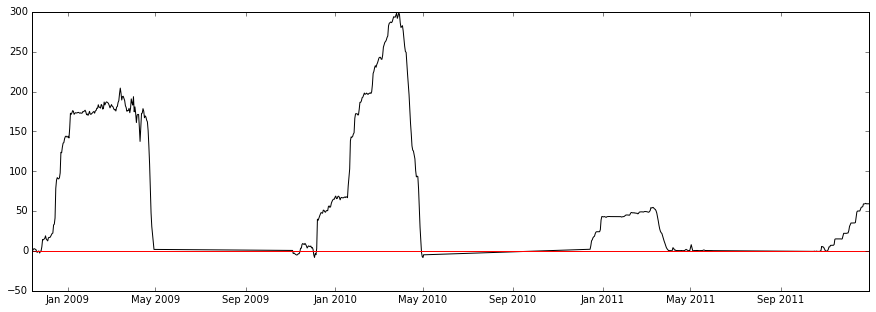

In [29]:
plt.figure(figsize=(15,5))
plt.plot(dat.index,dat.swe.interpolate('linear'),'-k',label='observations')
plt.axhline(0,c='r')